In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image
import numpy as np

import os 
import tensorflow as tf 
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np

from tensorflow.python.layers import base
import tensorflow.contrib.slim as slim

from keras import layers 
from keras import models
from keras.callbacks import EarlyStopping
import re

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read mapping table

mapping = pd.read_csv("dataset/mapping.txt", header=None)
class_num = len(mapping)
class_num

15

In [3]:
# setup picture size

train_tfrecord_length = 0
test_tfrecord_length = 0
target_width = 299
target_height = 299
target_channel = 3

In [4]:
# read y label

y_label_one_hot = keras.utils.to_categorical(mapping.iloc[:,1], class_num)
y_label_one_hot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [5]:
# covert to tfrecords format

def convert_to_tfrecords(dataset_path, data_folder):
    global train_tfrecord_length
    global test_tfrecord_length

    index = 0
    head = 1
    count_to_head = 0
    show_pic = 1

    writer= tf.python_io.TFRecordWriter(data_folder + ".tfrecords") #要生成的檔案

    if data_folder == "train":
        for class_name in mapping.iloc[:,0]:
            class_path = dataset_path + "/" + data_folder + "/" + class_name
            #print(class_path)

            count_to_head = 0
            for img_name in os.listdir(class_path):
                count_to_head += 1
                train_tfrecord_length += 1

                img_path = class_path + "/" + img_name

                try:
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    height, width, channel = image.shape
                    image = cv2.resize(image,(target_width, target_height))
                    image_raw = image.tostring()
                except:
                    print("err : " + img_path)

                
                if count_to_head <= head:
                    if show_pic == 1:
                        plt.imshow(image)
                        plt.show()
                        show_pic = 0
                    print(class_name + " (" + str(mapping.iloc[index, 1]) +") " + " : " + img_name)

                    

                example = tf.train.Example(features=tf.train.Features(feature={
                    "id": tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(img_name, encoding = "utf8")
    ])),
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[mapping.iloc[index, 1]])),
                    'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw]))
                }))
                writer.write(example.SerializeToString())

            index += 1

        writer.close()
        print(data_folder + "_tfrecord_length = " + str(train_tfrecord_length)) 
            
    else:
        
        class_path = dataset_path + "/" + data_folder
        #print(class_path)
        
        count_to_head = 0
        for img_name in sorted(os.listdir(class_path)):
            count_to_head += 1
            test_tfrecord_length += 1

            img_path = class_path + "/" + img_name

            try:
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                height, width, channel = image.shape
                image = cv2.resize(image,(target_width, target_height))
                image_raw = image.tostring()
            except:
                print("err : " + img_path)
            
            if count_to_head <= head:
                if show_pic == 1:
                    plt.imshow(image)
                    plt.show()
                    show_pic = 0
                
                print(img_name)



            example = tf.train.Example(features=tf.train.Features(feature={
                "id": tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(img_name, encoding = "utf8")
])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[mapping.iloc[index, 1]])),
                'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw]))
            }))
            writer.write(example.SerializeToString())

        writer.close()
        print(data_folder + "_tfrecord_length = " + str(test_tfrecord_length))
        


In [6]:
# create tfrecords

if os.path.isfile('./train.tfrecords')  == True :
    train_tfrecord_length = 2985
else:
    convert_to_tfrecords("dataset", "train")
    

if os.path.isfile('./testset.tfrecords')  == True :
    test_tfrecord_length = 1500
else:
    convert_to_tfrecords("dataset", "testset")


In [7]:
# cv2 augmentation

def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1

def Histograms_Equalization(img):
    equ = cv2.equalizeHist(img)
    return equ


In [8]:
# create tfrecords feature table

def decode_tfrecords(filename_queue):
    reader = tf.TFRecordReader()
    key, serialized_example = reader.read(filename_queue)

    img_features = tf.parse_single_example(
            serialized_example,
            features={'id':tf.FixedLenFeature([], tf.string),
                    'label':tf.FixedLenFeature([], tf.int64),
                    'image_raw': tf.FixedLenFeature([],tf.string)})
    idx = tf.cast(img_features['id'], tf.string)
    image = tf.decode_raw(img_features['image_raw'], tf.uint8)
    image = tf.reshape(image, [target_width, target_height, target_channel])
    label = tf.cast(img_features['label'], tf.int64)
    return idx, image, label

In [9]:
# read datasets from tfrecords

def convert_from_tfrecords(filename):
    filename_queue = tf.train.string_input_producer(
        [filename], num_epochs=1)
    idx, image, label = decode_tfrecords(filename_queue)
    
    head = 3
    i = 0
    idx_ls = []
    img_ls = []
    img_gray_ls = []
    label_ls = []
    label_one_hot_ls = []

    if filename == "train.tfrecords":
        tfrecord_length = train_tfrecord_length
    else:
        tfrecord_length = test_tfrecord_length
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        #建立多執行序處理輸入數據
        coord = tf.train.Coordinator()

        # 啟動文件隊列，開始讀取文件
        threads = tf.train.start_queue_runners(coord=coord)
        count = 0 
        try:
            print(tfrecord_length)
            for i in range(tfrecord_length):

                idx_data, image_data, label_data = sess.run([idx, image, label])
                idx_ls.append(idx_data)
                
                img_ls.append(image_data)
                
                img_gray = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
                img_gray_ls.append(img_gray)
                
                label_ls.append(label_data)
                onehot = np.zeros(class_num)  
                onehot[label_data] = 1
                label_one_hot_ls.append(onehot)
                
                if i < head:
                    plt.imshow(image_data)
                    #plt.imshow(img_gray)
                    plt.show()
                    print(img_gray.shape)
                    print(label_data)
                    print(onehot)
                    print(idx_data)

        except tf.errors.OutOfRangeError:
            print('Done!')
        finally:
            coord.request_stop()

        coord.join(threads)
        
    return idx_ls, img_ls, img_gray_ls, label_ls, label_one_hot_ls

2985


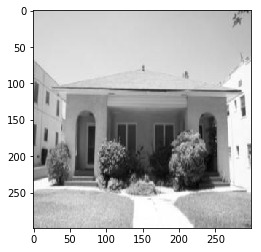

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'image_0041.jpg'


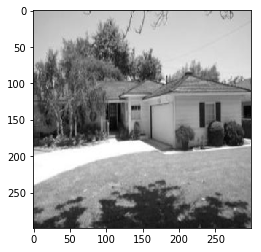

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'image_0082.jpg'


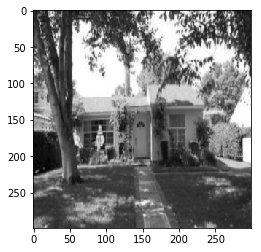

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'image_0139.jpg'


2985

In [10]:
# read training data

train_idx, train_image, train_image_gray, train_label, train_label_one_hot = convert_from_tfrecords("train.tfrecords")
len(train_idx)

1500


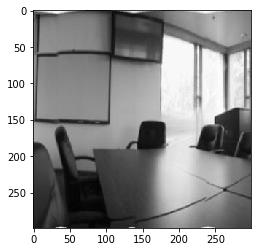

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2.jpg'


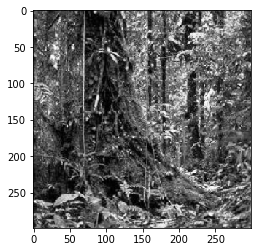

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570bb88085b3484a50afc.jpg'


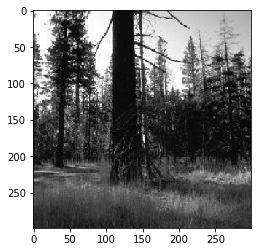

(299, 299)
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369fd77ff8fdf6493c5e7.jpg'


1500

In [11]:
# read testing data

test_idx, test_image, test_image_gray, test_label, test_label_one_hot = convert_from_tfrecords("testset.tfrecords")
len(test_idx)

In [12]:
# CNN accuracy : 0.591 ~ 0.66 

def CNN():
    global target_width
    global target_height
    
    epochs = 30
    model = models.Sequential() 

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3))) # 加入 Covn2d 層
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(class_num, activation='softmax'))

    #model.summary()
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    
    
    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.13,
                                                    stratify=train_label
                                                    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    #history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping])
    
    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False)

    datagen.fit(X_train)

    # 使用实时数据增益的批数据对模型进行拟合：
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=datagen.flow(X_test, y_test, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=epochs, callbacks=[early_stopping])
    
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)
    
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('CNN.h5')


In [13]:
# CNN1 accuracy : 0.63 ~ 0.69

def CNN1():
    global target_width
    global target_height
    
    epochs = 30
    model = models.Sequential() 

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_width, target_height, 3))) # 加入 Covn2d 層
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(class_num, activation='softmax'))

    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    
    
    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)
    

    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    #history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping])
    
    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    datagen.fit(x_data)

    
    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                y_data, 
                                                test_size=0.13,
                                                stratify=train_label
                                                )

    
    # 使用实时数据增益的批数据对模型进行拟合：
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=datagen.flow(X_test, y_test, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=epochs, callbacks=[early_stopping])
    
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)
    
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('CNN1.h5')
    

In [14]:
# DNN accuracy : 0.219

def DNN():
    
    #data
    x_data = np.array(train_image_gray).reshape(train_tfrecord_length, -1)  # flatten image data
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.13,
                                                    stratify=train_label
                                                    )
    
    
    #create model
    tf.reset_default_graph()

    isTraining = True
    with tf.name_scope('placeholder'):
        input_data = tf.placeholder(tf.float32, shape=[None, target_width*target_height], name='X')
        y_true = tf.placeholder(tf.float32, shape=[None, class_num], name='y')

    with tf.variable_scope('network'):
        h1 = tf.layers.dense(input_data, 256, activation=tf.nn.relu, name='hidden1')  # try to change the activation function
        h2 = tf.layers.dense(h1, 128, activation=tf.nn.relu, name='hidden2')
        h3 = tf.layers.dense(h2, 64, activation=tf.nn.relu, name='hidden3')
        dropout = tf.layers.dropout(
          inputs=h3, rate=0.4, training=isTraining)
        out = tf.layers.dense(dropout, class_num, name='output')

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out), name='loss')

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(out), 1), tf.argmax(y_true, 1))
        compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.name_scope('opt'):
        update = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss) # try to change the optimuizer and learning rate

    init = tf.global_variables_initializer()
    

    #summary
    tf.global_variables()
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)
    
    
    #training
    epoch = 100
    bs = 32

    train_loss_epoch, train_acc_epoch = [], []
    test_loss_epoch, test_acc_epoch = [], []

    sess = tf.Session()
    sess.run(init)

    for i in tqdm_notebook(range(epoch)):

        #training part
        train_loss_batch, train_acc_batch = [], []

        total_batch = len(X_train) // bs

        for j in range(total_batch):

            X_batch = X_train[j*bs : (j+1)*bs]
            y_batch = y_train[j*bs : (j+1)*bs]
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, update], 
                                                feed_dict={input_data: X_batch, y_true: y_batch})

            train_loss_batch.append(batch_loss)
            train_acc_batch.append(batch_acc)

        train_loss_epoch.append(np.mean(train_loss_batch))
        train_acc_epoch.append(np.mean(train_acc_batch))

        #testing part
        isTraining = False
        batch_loss, batch_acc = sess.run([loss, compute_acc], 
                                        feed_dict={input_data: X_test, y_true: y_test})

        test_loss_epoch.append(batch_loss)
        test_acc_epoch.append(batch_acc)

        X_train, y_train = shuffle(X_train, y_train)

        if i%5 == 0:
            print('step: {:2d}, train loss: {:.3f}, train acc: {:.3f}, test loss: {:.3f}, test acc: {:.3f}'
                 .format(i, train_loss_epoch[i], train_acc_epoch[i], test_loss_epoch[i], test_acc_epoch[i]))
            
            
    sess.close()
    
    
    plt.plot(train_loss_epoch, 'b', label='train')
    plt.plot(test_loss_epoch, 'r', label='test')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(train_acc_epoch, 'b', label='train')
    plt.plot(test_acc_epoch, 'r', label='test')
    plt.legend()
    plt.title("Accuracy")
    plt.show()
    

In [15]:
# VGG16 transfer learning 0.75

def VGG16_TRANSFER():
    
    global target_width
    global target_height

    epochs = 100

    vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
    model = Sequential(vgg16.layers)

    for layer in model.layers[:15]:
        layer.trainable = False

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(class_num, activation='softmax'))

    #model.summary()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )

    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)



    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    #history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=64, callbacks=[early_stopping])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    datagen.fit(x_data)


    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                y_data, 
                                                test_size=0.13,
                                                stratify=train_label
                                                )


    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        validation_data=datagen.flow(X_test, y_test, batch_size=32),
                        validation_steps=len(X_test) / 32,
                        steps_per_epoch=len(X_train) / 32, epochs=epochs, callbacks=[early_stopping])


    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)


    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('VGG16_TRANSFER.h5')

In [16]:
# DENSENET transfer learning 0.86

def DENSENET_TRANSFER():
    
    global target_width
    global target_height

    epochs = 100

    base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(target_width, target_height, 3))

    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(class_num, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)


    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)


    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                            y_data, 
                                            test_size=0.13,
                                            stratify=train_label,
                                            random_state=7
                                            )
    
    
    datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

    optimizer = keras.optimizers.Adam(lr=10e-6)

    model_path = 'DENSENET_TRANSFER.h5'

    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    batch_size = 16
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                        epochs = epochs,
                                        validation_data = (X_test, y_test),
                                        callbacks = [checkpoint, earlystop])

    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)


    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('DENSENET_TRANSFER.h5')

In [17]:
# XCEPTION transfer learning 0.84

def XCEPTION_TRANSFER():
    
    global target_width
    global target_height

    epochs = 100


    img_rows, img_cols, img_channel = target_width, target_height, 3
    base_model = Xception(weights='imagenet', include_top=False,
                             input_shape=(img_rows, img_cols, img_channel))

    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(class_num, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)


    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)


    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                            y_data, 
                                            test_size=0.13,
                                            stratify=train_label,
                                            random_state=7
                                            )
    
    
    datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')


    optimizer = keras.optimizers.Adam(lr=10e-6)
    model_path = 'XCEPTION_TRANSFER.h5'

    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    batch_size = 16
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                        epochs = epochs,
                                        validation_data = (X_test, y_test),
                                        callbacks = [checkpoint, earlystop])
    
    

    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)


    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('XCEPTION_TRANSFER.h5')

In [18]:
# GoogleNet transfer learning 0.84

def GOOGLENET_TRANSFER():
    
    global target_width
    global target_height

    epochs = 100

    
    img_rows, img_cols, img_channel = target_width, target_height, 3
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(class_num, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)




    x_data = np.array(train_image).reshape(train_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    y_data = np.array(train_label_one_hot)


    X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                            y_data, 
                                            test_size=0.13,
                                            stratify=train_label,
                                            random_state=7
                                            )
    
    
    datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')


    optimizer = keras.optimizers.Adam(lr=10e-6)
    model_path = 'GOOGLENET_TRANSFER.h5'

    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    batch_size = 16
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                        epochs = epochs,
                                        validation_data = (X_test, y_test),
                                        callbacks = [checkpoint, earlystop])
    
    

    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(test_acc)


    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    model.save('GOOGLENET_TRANSFER.h5')

In [19]:
# prediction

def predict(model_name):
    model = None
    
    if model_name == "VGG16_TRANSFER.h5":
        
        # create graph and load weight
        vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
        model = Sequential(vgg16.layers)

        for layer in model.layers[:15]:
            layer.trainable = False

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(class_num, activation='softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=SGD(lr=1e-4, momentum=0.9),
            metrics=['accuracy']
        )
        model.load_weights(model_name)
        
        
    elif model_name == "DENSENET_TRANSFER.h5":
        
        # create graph and load weight
        base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(target_width, target_height, 3))

        x = base_model.output
        x = GlobalAveragePooling2D(data_format='channels_last')(x)
        #x = Dropout(0.5)(x)
        predictions = Dense(class_num, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)
        optimizer = keras.optimizers.Adam(lr=10e-6)

        model_path = 'DENSENET_TRANSFER.h5'

        checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer, metrics=['accuracy'])
        model.load_weights(model_name)
    
    
    
    elif model_name == "XCEPTION_TRANSFER.h5":
        
        # create graph and load weight
        base_model = Xception(weights='imagenet', include_top=False,
                         input_shape=(target_width, target_height, 3))

        x = base_model.output
        x = GlobalAveragePooling2D(data_format='channels_last')(x)
        #x = Dropout(0.5)(x)
        predictions = Dense(class_num, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        model.load_weights(model_name)
    
    
    elif model_name == "GOOGLENET_TRANSFER.h5":
        
        # create graph and load weight
        base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                         input_shape=(target_width, target_height, 3))

        x = base_model.output
        x = GlobalAveragePooling2D(data_format='channels_last')(x)
        #x = Dropout(0.5)(x)
        predictions = Dense(class_num, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        model.load_weights(model_name)
        
    
    else :
        # load graph and weight
        model = tf.keras.models.load_model(model_name)
    
    
    # predict
    x_data = np.array(test_image).reshape(test_tfrecord_length, target_width, target_height, 3)
    x_data = x_data / 255.  # normalization
    
    
    if model_name == "DENSENET_TRANSFER.h5" or model_name == "XCEPTION_TRANSFER.h5" or model_name == "GOOGLENET_TRANSFER.h5":
        y_test_pred_prob = model.predict(x_data)
        y_predict = y_test_pred_prob.argmax(axis=-1)
    else:
        y_predict = model.predict_classes(x_data)

    
    # create csv output
    y_id = [idx.decode("utf-8") for idx in test_idx]
    y_id = [re.sub('\.jpg$', '', idx) for idx in y_id]

    data = list(zip(y_id, y_predict))
    df = pd.DataFrame(data, columns=['id', 'class'])
    df.to_csv("20190907_at082022_submission.csv", index=0)
    print(df.head())
    
    
    # verify predict picture
    idx = 0
    plt.imshow(test_image[idx])
    plt.show()
    print(test_label[idx])
    print(test_label_one_hot[idx])
    print(test_idx[idx])
    print(y_predict[idx])
    
    return y_predict
    

                                                  id  class
0  001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...      5
1  00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...      4
2  003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...      4
3  013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...      8
4  0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...     10


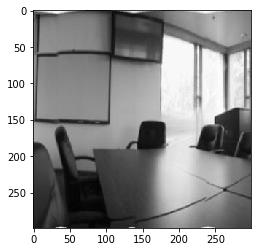

9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2.jpg'
5
                                                  id  class
0  001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...      7
1  00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...      4
2  003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...      4
3  013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...      8
4  0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...     10


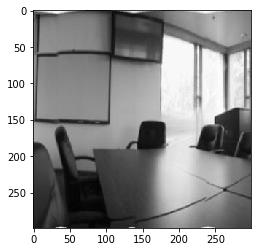

9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
b'001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf8c7115f5eb033bc3d2.jpg'
7


In [21]:
# training

#DNN()
#CNN()
#CNN1()
#VGG16_TRANSFER()
DENSENET_TRANSFER()
#XCEPTION_TRANSFER()
#GOOGLENET_TRANSFER()

# prediction

#predict("CNN1.h5")
#predict("VGG16_TRANSFER.h5")
d = predict("DENSENET_TRANSFER.h5")
#x = predict("XCEPTION_TRANSFER.h5")
#g = predict("GOOGLENET_TRANSFER.h5")

In [26]:

y_pred = []
for i in range(test_tfrecord_length):
    en = np.zeros((15,), dtype=int)
    en[d[i]] += 1
    en[x[i]] += 1
    en[g[i]] += 1
    
    if d[i] != x[i] and g[i] != x[i] and g[i] != d[i]:
        print(str(test_idx[i]) + ", i = " + str(i) + ", d[i] = " + str(d[i]) + ", x[i] = " + str(x[i]) + ", g[i] = " + str(g[i]))
        y_pred.append(x[i])
    else: 
        y_pred.append(np.argmax(en))

#print(y_pred)
    
y_id = [idx.decode("utf-8") for idx in test_idx]
y_id = [re.sub('\.jpg$', '', idx) for idx in y_id]

data = list(zip(y_id, y_pred))
df = pd.DataFrame(data, columns=['id', 'class'])
df.to_csv("ensemble_submission.csv", index=0)
print(df.head()) 

b'018acbc4bfcf84ec108daed576b32d3cf58b1396126929b6fe59e0f07a095b7f.jpg', i = 6, d[i] = 8, x[i] = 13, g[i] = 4
b'037fbf0b0cc759d4f410d779162e51b68f76011657cda1a4028cab31c95ead4d.jpg', i = 21, d[i] = 14, x[i] = 9, g[i] = 3
b'0a096342eb94225f40c02781eaba2c1c29551acb17adcc05451e4e35f4e4cea2.jpg', i = 61, d[i] = 12, x[i] = 5, g[i] = 0
b'1639a85a3a82e89d66980c2c865ad240cfc4b4330e7f7cdb47286702a05d0099.jpg', i = 139, d[i] = 10, x[i] = 6, g[i] = 8
b'313be037ebc8b1683fbde95f012fc8d628e6fd5e5b7db0372efd821856e272a9.jpg', i = 293, d[i] = 1, x[i] = 3, g[i] = 13
b'4407afc40a9e8387d9bd30c6a2d8889e1438fb4087e925ef7eaa535f0bd61689.jpg', i = 413, d[i] = 2, x[i] = 9, g[i] = 3
b'47ee718990dc5705751779beefc5020c68f023ca1f9a504b68e790f8df316ce8.jpg', i = 435, d[i] = 3, x[i] = 2, g[i] = 14
b'5132a0f9ed15a380cea450c2b7136663fac913523f9b656ddca5cef01439152f.jpg', i = 497, d[i] = 3, x[i] = 12, g[i] = 5
b'5787b1b3855a32374657332bf7ab48c9d337bd4271287613a54b2398220ce4ae.jpg', i = 526, d[i] = 11, x[i] = 0, g[i] =